# Dissecting Spotify Valence

This is the third assignment for the course of **Practical Data Science**

---

> Konstantinos Kostis, p3352311 <br />
> MSc Data Science (Part-Time) <br />
> Athens University of Economics and Business <br />
> kon.kostis@aueb.gr

## Notes to reader

- Important: This notebook takes about 1 hour to run :-)
- If you need to run the notebook you must have installed:
  - numpy, pandas, sklearn, matplotlib, seaborn, statsmodels
  - [xgboost](https://xgboost.readthedocs.io/en/stable/install.html)
  - [LightGBM](https://lightgbm.readthedocs.io/en/stable/Installation-Guide.html)
  - [FAISS](https://github.com/facebookresearch/faiss/blob/main/INSTALL.md)
  - [mlxtend](https://rasbt.github.io/mlxtend/)
- If you need to run the notebook, you will find enclosed a **environment.yml** file ready to be imported into conda. Otherwise,
  feel free to use the provided **requirements.txt** file!

In [1]:
# import libraries
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import faiss

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

%matplotlib inline

## Data Preparation

First of all, we need to collect data.

- From the [Music Genre Dataset (Zenodo)](https://zenodo.org/records/4778563) download the **hit_songs.zip** (Contains hit song data and features)
- Download from Kaggle a dataset containing 1.2+ million songs. You can find it [here](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs)

Next, we will read the above data into pandas dataframes and

- Drop un-needed columns (If needed)
- Rename columns (If needed)
- Properly combine (concat or merge) them together.

In [2]:
# A global random seed for reproducibility
global_random_seed = 23122023

In [3]:
# Read spotify hits dataset
spotify_hits = pd.read_csv('data/spotify_hits_dataset_complete.csv', sep='\t')

print(spotify_hits.columns)
spotify_hits.head()

Index(['song_id', 'song_name', 'artist_id', 'artist_name', 'popularity',
       'explicit', 'song_type', 'track_number', 'num_artists',
       'num_available_markets', 'release_date', 'duration_ms', 'key', 'mode',
       'time_signature', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo'],
      dtype='object')


,song_id,song_name,artist_id,artist_name,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,16GAMmkIzTIT7aH19TtW3f,Show You,['6M25WWmNO7wK1DnKmd3z6R'],['CXLOE'],45,False,Solo,1,1,79,...,4,0.00560,0.636,0.693,0.000604,0.1140,-6.014,0.0647,0.388,96.090
1,0MET90crciVlxlE07ub7Rn,Good Love (feat. Tory Lanez),"['3dKjmeRZcSUw617CoMzEA0', '2jku7tDXc6XoB6MO2h...","['Nafe Smallz', 'Tory Lanez']",58,True,Collaboration,1,2,79,...,3,0.02090,0.614,0.641,0.000000,0.0659,-6.751,0.2880,0.492,123.539
2,7BpYWzZwrsljT1eIjb0TqR,Told You So,['74XFHRwlV6OrjEM0A2NCMF'],['Paramore'],61,False,Solo,3,1,79,...,4,0.00290,0.639,0.814,0.000030,0.0529,-5.632,0.0385,0.904,123.922
3,2GrYIUrAYK5TZhSh0RJV6H,Fantastic Boy,['4Kxlr1PRlDKEB0ekOCyHgX'],['BIGBANG'],0,False,Solo,4,1,0,...,4,0.00231,0.725,0.836,0.000000,0.0927,-3.927,0.0571,0.544,130.053
4,7G7P0AOE4mXWvdSSroLfZA,Told You,['31lnFZEM6ysvjOx59VyxRE'],['Krept & Konan'],0,True,Solo,2,1,0,...,4,0.08830,0.854,0.552,0.000019,0.1510,-7.065,0.0419,0.102,127.966


In [4]:
# Drop columns (un-needed metadata)
columns_to_drop = ['song_name', 'artist_id', 'artist_name',
                   'popularity', 'song_type', 'track_number',
                   'num_artists', 'num_available_markets', 'release_date']

spotify_hits = spotify_hits.drop(columns=columns_to_drop)

In [5]:
# Read the kaggle dataset (1.2M songs)
spotify_kaggle = pd.read_csv('data/tracks_features.csv.zip')
print(spotify_kaggle.columns)
spotify_kaggle.head()

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'year', 'release_date'],
      dtype='object')


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [6]:
# Drop columns (un-needed metadata)
columns_to_drop = ['name', 'album', 'album_id',
                   'artists', 'artist_ids', 'track_number',
                   'disc_number', 'year', 'release_date']

spotify_kaggle = spotify_kaggle.drop(columns=columns_to_drop)

# Rename column id to song_id
spotify_kaggle.rename(columns = {'id': 'song_id'}, inplace = True)

In [7]:
# Concat the dataframes and drop duplicates
spotify_tracks = pd.concat([spotify_hits, spotify_kaggle])
spotify_tracks = spotify_tracks.drop_duplicates(subset='song_id')

# Convert explicit to integer
spotify_tracks['explicit'] = spotify_tracks['explicit'].astype(int)

# Convert time_signature to integer
spotify_tracks['time_signature'] = spotify_tracks['time_signature'].astype(int)

In [8]:
# Describe the data
print("Data shape: {}".format(spotify_tracks.shape))
print(spotify_tracks.dtypes)
spotify_tracks.describe().T

Data shape: (1216203, 15)
song_id              object
explicit              int64
duration_ms           int64
key                   int64
mode                  int64
time_signature        int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
valence             float64
tempo               float64
dtype: object


,count,mean,std,min,25%,50%,75%,max
explicit,1216203.0,0.072930,0.260022,0.0,0.000000,0.00000,0.0000,1.000
duration_ms,1216203.0,248421.398961,161525.527680,1000.0,174160.000000,223929.00000,285128.5000,6061090.000
key,1216203.0,5.195878,3.537818,0.0,2.000000,5.00000,8.0000,11.000
mode,1216203.0,0.669965,0.470226,0.0,0.000000,1.00000,1.0000,1.000
time_signature,1216203.0,3.833984,0.559346,0.0,4.000000,4.00000,4.0000,5.000
acousticness,1216203.0,0.444829,0.384445,0.0,0.038000,0.38300,0.8580,0.996
danceability,1216203.0,0.495022,0.190241,0.0,0.358000,0.50300,0.6350,1.000
energy,1216203.0,0.511121,0.294063,0.0,0.255000,0.52700,0.7670,1.000
instrumentalness,1216203.0,0.280098,0.375444,0.0,0.000007,0.00714,0.7120,1.000
liveness,1216203.0,0.201407,0.180233,0.0,0.096800,0.12500,0.2450,1.000


**Observations**

Based on the [description of features](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) key, mode and
explicit are categorical variables. The key will be one-hot encoded. The mode and explicit are already binary.
The other features are numerical and will be treated as such.
The standard deviation varies among numerical features so we could use the standardization technique.

### Dummy variables & Standardization

In [9]:
spotify_tracks_dummies = pd.get_dummies(spotify_tracks.copy(), columns=['key'], drop_first=True)
spotify_tracks_dummies.set_index('song_id', inplace=True)

columns = list(set(spotify_tracks_dummies.columns) - set(['valence']))

standard_scaler = StandardScaler()
spotify_tracks_transformed = spotify_tracks_dummies.copy()
spotify_tracks_transformed[columns] = standard_scaler.fit_transform(spotify_tracks_transformed[columns])

## Q1: Explore which Track Features Influence Valence

In order to find which features influence valence we will create a set of methods and/or classes in order to
implement the following methodology:

- Create visualizations for all features (histogram plots).
- Process the data by applying standardization (numerical features) and dummy-variables creation (categorical features).
- Display the correlation matrix, to get an idea of what features are linearly correlatated with (and may influence) valence
- For categorical features, use ANOVA to test for correlation.
- Calculate the Variance-Inflation-Factor to check for multi-colinearity (bonus)
- Split the data using train_test_split at an 80/20 ratio.
- Create a baseline linear-regression model with all the features. Predict on the test set. Record $R^2$, $R_{adj}^2$, AIC for training and MAE for test.
- Using step-wise regression (forward and backward) derive 2 models. Predict on the test set. Record the same metrics as above.
- From the 3 models above, select the best one by utilizing the recorded metrics.
- Utilize statsmodels, with the formula of the selected best model. Comment on influence of features on valence and their statistical significance.

### Visualizations (Distribution/Histogram plots)

Lets create a set of histograms to have an idea regarding the distributions of our features

array([[<Axes: title={'center': 'explicit'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>, <Axes: >, <Axes: >]],
      dtype=object)

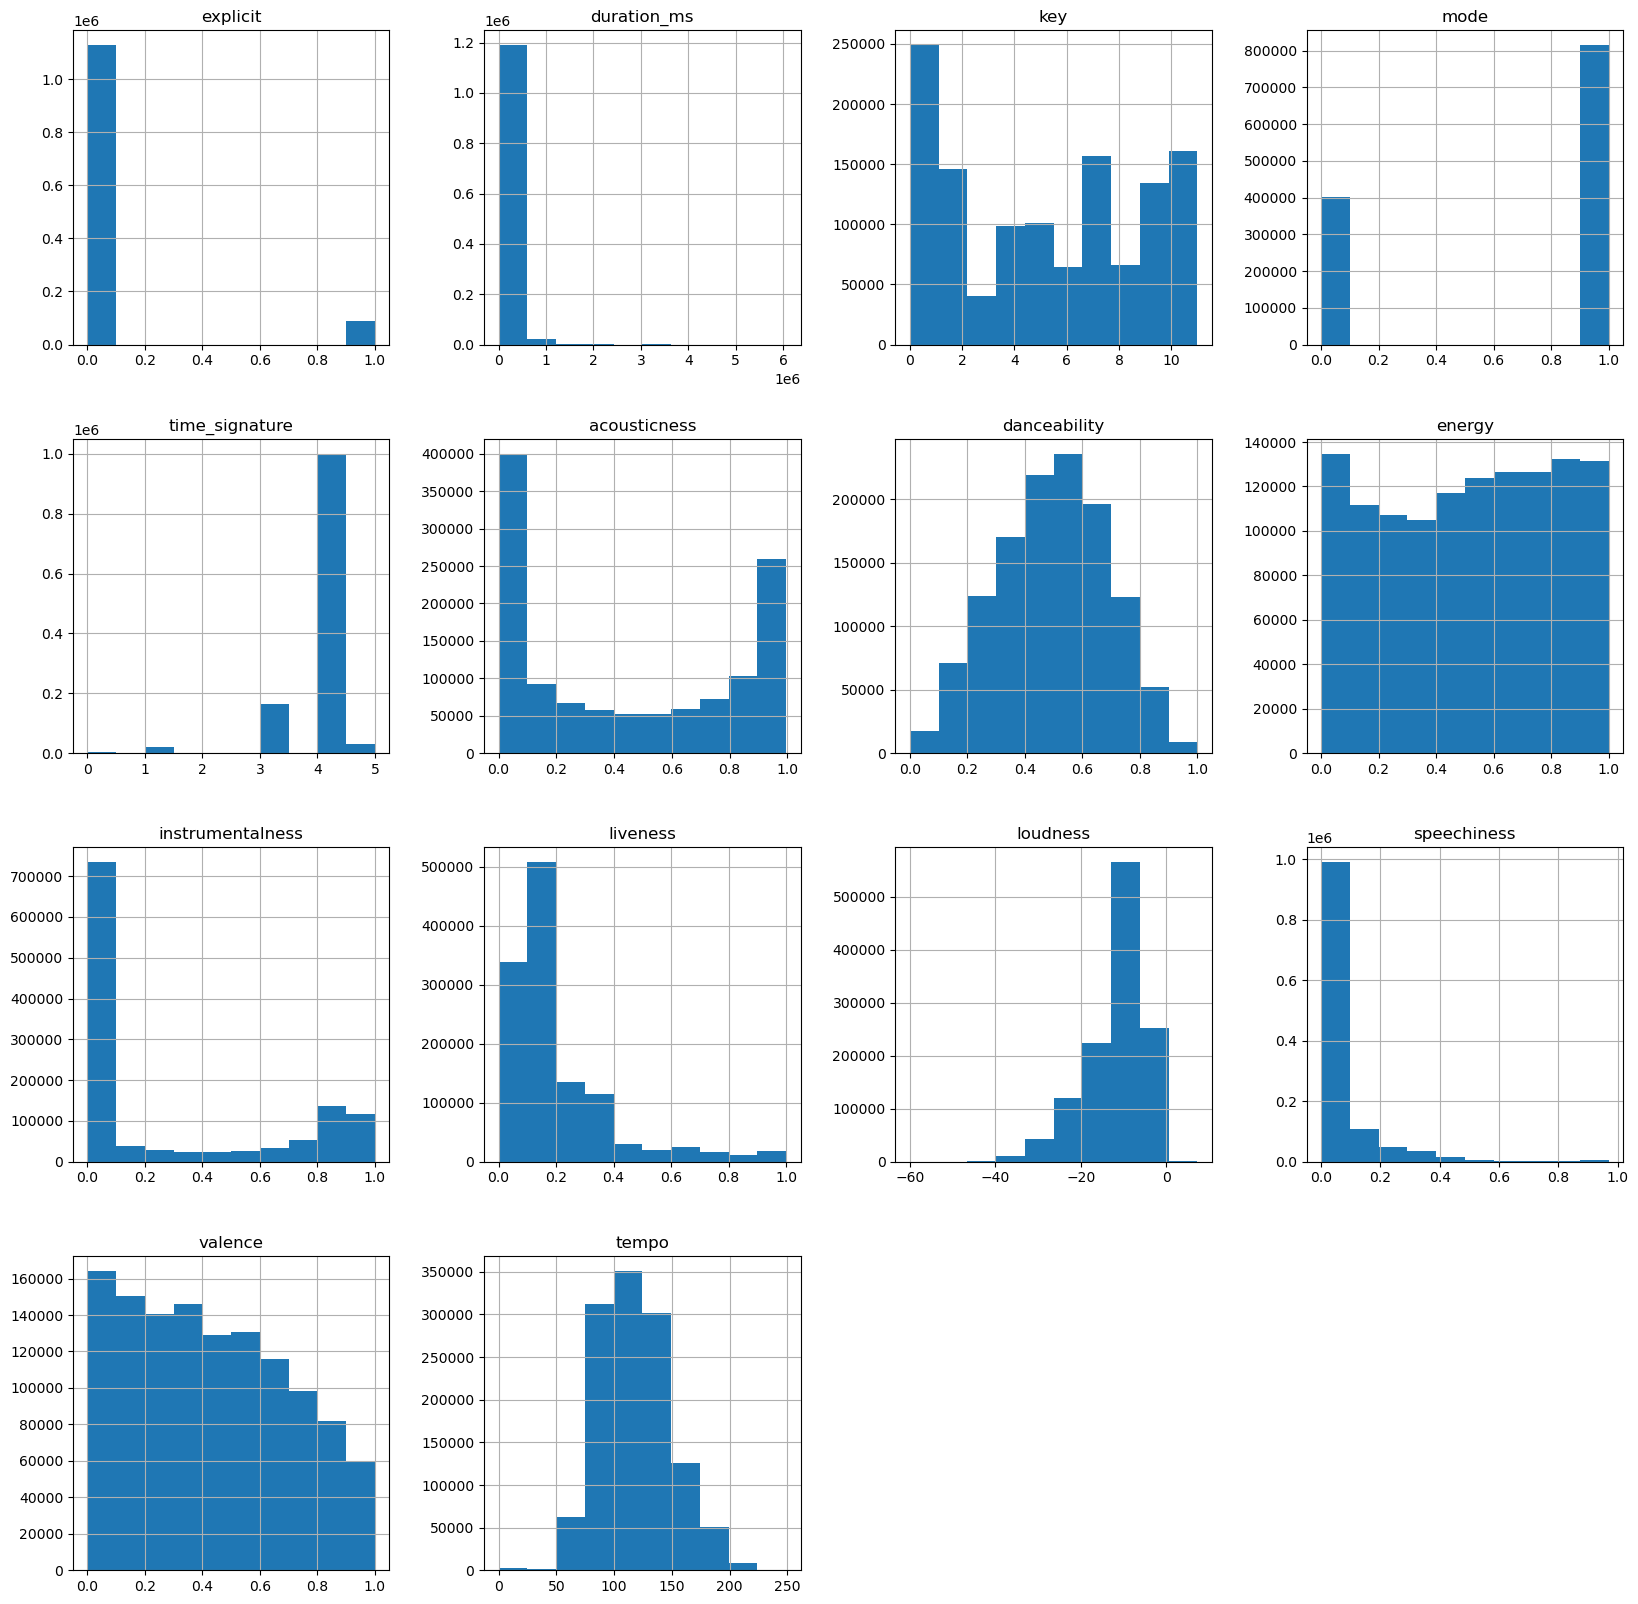

In [10]:
spotify_tracks.hist(figsize=(20, 20))

### Correlation Matrix

Lets compute and visualize the correlations matrix to get an idea about which features may influence valence.

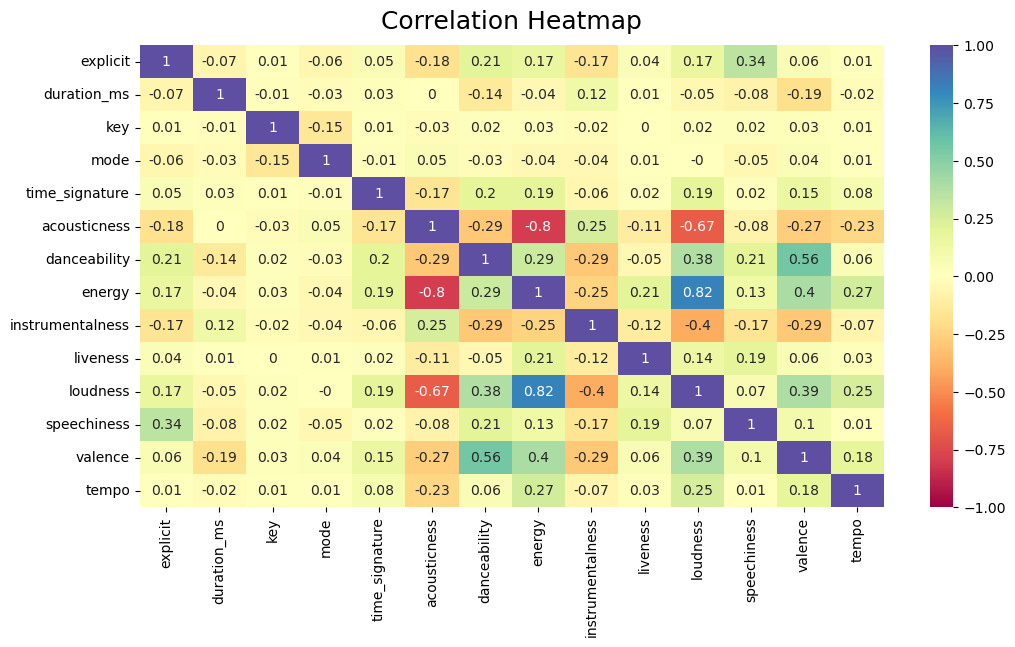

In [11]:
tracks_features = spotify_tracks.set_index('song_id')
cor = round(tracks_features.corr(), 2)
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(cor, vmin=-1, vmax=1, annot=True, cmap="Spectral")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

**Observations**

From the correlation matrix above we can see that features that stand out regarding correlation (positive and negative) to valence are:

- danceability (0.56)
- energy (0.4)
- loudness (0.39)
- instrumentalness (-0.29)
- acousticness (-0.27)

### Correlation to valence for categorical variables via ANOVA

The features key, mode and valence are categorical. Hence, we can use the ANOVA method to see if the levels
of each categorical variable do have an influence on valence. This is tested via an F-test for the equality of
means of each level of the tested categorical variable. We assume a significance level of 0.05.

In [12]:
key_model = smf.ols('valence ~ C(key)', data=spotify_tracks).fit()
sm.stats.anova_lm(key_model, typ=2)

,sum_sq,df,F,PR(>F)
C(key),259.022108,11.0,323.729222,0.0
Residual,88463.482131,1216191.0,NaN,NaN


In [13]:
mode_model = smf.ols('valence ~ C(mode)', data=spotify_tracks).fit()
sm.stats.anova_lm(mode_model, typ=2)

,sum_sq,df,F,PR(>F)
C(mode),124.390394,1.0,1707.527564,0.0
Residual,88598.113845,1216201.0,NaN,NaN


In [14]:
explicit_model = smf.ols('valence ~ C(explicit)', data=spotify_tracks).fit()
sm.stats.anova_lm(explicit_model, typ=2)

,sum_sq,df,F,PR(>F)
C(explicit),290.669449,1.0,3997.570283,0.0
Residual,88431.834790,1216201.0,NaN,NaN


**Observations**

The ANOVA indicated that key, mode and explicit are all statistically significant regarding the influnce on valence when checked individually,
reporting a p-value of 0 (zero).

### Testing for multi-colinearity using Variance Inflation Factor (This is a bonus section)

In [15]:
# Create a class for Multi-colinearity detection using VIF
class VIFMulticolinearity:
    def __init__(self, threshold = 10.0):
        self.vif_data = pd.DataFrame()
        self.removed = []
        self.threshold = threshold
        self.iterations = 0

    def detect(self, data):
        done = False

        columns = list(data.columns)

        while done is False:
            self.iterations += 1

            vif_df, to_remove = self.run_for(data, columns)
            self.vif_data = vif_df
            
            if to_remove is None:
                done = True
            else:
                columns.remove(to_remove)
                self.removed.append(to_remove)

    def run_for(self, data, columns):
        vif_df = pd.DataFrame()

        vif_df['feature'] = columns
        df_data = data[columns]

        vif_df["VIF"] = [variance_inflation_factor(df_data.values, i) 
                          for i in range(len(columns))]

        vif_df = vif_df.sort_values(by=['VIF'], ascending=False)

        to_remove = None

        # get the row with the max value of VIF
        row = vif_df[vif_df['VIF']==vif_df['VIF'].max()]

        if row['VIF'].values[0] > self.threshold:
            to_remove = row['feature'].values[0]

        return vif_df, to_remove

In [16]:
data = spotify_tracks_dummies.replace({False: 0, True: 1})

detector = VIFMulticolinearity()
detector.detect(data)

print("Removed (virtually) due to large VIF: {}".format(detector.removed))
detector.vif_data

Removed (virtually) due to large VIF: ['time_signature', 'tempo', 'danceability']


,feature,VIF
4,energy,8.542742
7,loudness,7.841609
3,acousticness,5.136673
9,valence,4.478352
1,duration_ms,3.338665
2,mode,3.112882
6,liveness,2.476901
5,instrumentalness,2.040904
16,key_7,1.917783
8,speechiness,1.881223


### Linear Regression for features that influence valence

We will use the Sequential Feature Selector from mlxtend in order to run Forward and Backward selection. These, do not guarantee to find the best model
but unfortunately running the Best-Subset-Selection algorithm with 23 variables will take a very long time.

In [17]:
# Stepwise feature selection (forward, backward and baseline)
class StepwiseFeatureSelection:
    def __init__(self, significance_level = 0.05):
        self.significance_level = significance_level

    def baseline(self, X, y):
        features = X.columns.to_list()
        features_with_constant = sm.add_constant(X[features])
        model = sm.OLS(y, features_with_constant).fit()

        return (features, model)

    def r2_score_adj(self, estimator, X, y):
        y_pred = estimator.predict(X)

        if estimator.fit_intercept:
            rsquared = 1 - np.nansum((y - y_pred) ** 2) / np.nansum((y - np.nanmean(y)) ** 2)
            rsquared_adj = 1 - (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1) * (1 - rsquared)
    
        else:
            rsquared = 1 - np.nansum((y - y_pred) ** 2) / np.nansum(y ** 2)
            rsquared_adj = 1 - X.shape[0] / (X.shape[0] - X.shape[1]) * (1 - rsquared)
    
        return rsquared_adj
    

    def forward_selection(self, X, y):
        lr = LinearRegression()

        sfs = SFS(lr, 
                   k_features='best', 
                   forward=True, 
                   floating=False, 
                   verbose=2,
                   scoring=self.r2_score_adj,
                   cv=0)
    
        fitted = sfs.fit(X, y)

        best_features = list(fitted.k_feature_names_)

        selected_model = sm.OLS(y, sm.add_constant(X[best_features])).fit()

        return (best_features, selected_model)

    def backward_elimination(self, X, y):
        lr = LinearRegression()

        sfs = SFS(lr, 
                   k_features='best', 
                   forward=False, 
                   floating=False, 
                   verbose=2,
                   scoring=self.r2_score_adj,
                   cv=0)

        fitted = sfs.fit(X, y)

        best_features = list(fitted.k_feature_names_)

        selected_model = sm.OLS(y, sm.add_constant(X[best_features])).fit()

        return (best_features, selected_model)

In [18]:
# A class for finding the best linear-regression model
# in order to later check which features influence valence.
class LRBestModelFinder:
    def __init__(self, data, test_size=0.2, seed=global_random_seed):
        self.best_models = {}
        self.results_df = pd.DataFrame({
            'Model': ['Baseline', 'Forward-Selection', 'Backward-Selection'],
            'R_Squared': [0.0, 0.0, 0.0],
            'R_Squared_Adjusted': [0.0, 0.0, 0.0],
            'AIC': [0.0, 0.0, 0.0],
            'MAE': [0.0, 0.0, 0.0]
        })

        self.models = {}

        self.test_size = test_size
        self.seed = global_random_seed

        self.decimals = 6
        
        self.y = data['valence']
        self.X = data.drop(columns=['valence'])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.seed)

        self.feature_selection = StepwiseFeatureSelection()

    def discover(self):
        self.baseline()
        self.forward_selection()
        self.backward_selection()

    def baseline(self):
        features, model = self.feature_selection.baseline(self.X_train.copy(), self.y_train.copy())

        self.models['baseline'] = model
        
        # Record R2, R2_adj and AIC on train set, via stats models
        self.results_df.at[0, 'R_Squared'] = model.rsquared
        self.results_df.at[0, 'R_Squared_Adjusted'] = model.rsquared_adj
        self.results_df.at[0, 'AIC'] = model.aic

        # Predict on test set
        test_set = sm.add_constant(self.X_test[features].copy())
        predictions = model.predict(test_set)

        # Record MAE on test set
        self.results_df.at[0, 'MAE'] = round(mean_absolute_error(self.y_test.copy(), predictions), self.decimals)

    def forward_selection(self):
        features, model = self.feature_selection.forward_selection(self.X_train.copy(), self.y_train.copy())

        print('Done with forward')

        self.models['forward'] = model

        # Record R2, R2_adj and AIC on train set, via stats models
        self.results_df.at[1, 'R_Squared'] = model.rsquared
        self.results_df.at[1, 'R_Squared_Adjusted'] = model.rsquared_adj
        self.results_df.at[1, 'AIC'] = model.aic

        # Predict on test set
        test_set = sm.add_constant(self.X_test[features].copy())
        predictions = model.predict(test_set)

        # Record MAE on test set
        self.results_df.at[1, 'MAE'] = round(mean_absolute_error(self.y_test.copy(), predictions), self.decimals)

    def backward_selection(self):
        features, model = self.feature_selection.backward_elimination(self.X_train.copy(), self.y_train.copy())

        print('Done with backward')

        self.models['backward'] = model
        
        # Record R2, R2_adj and AIC on train set, via stats models
        self.results_df.at[2, 'R_Squared'] = model.rsquared
        self.results_df.at[2, 'R_Squared_Adjusted'] = model.rsquared_adj
        self.results_df.at[2, 'AIC'] = model.aic

        # Predict on test set
        test_set = sm.add_constant(self.X_test[features].copy())
        predictions = model.predict(test_set)

        # Record MAE on test set
        self.results_df.at[2, 'MAE'] = round(mean_absolute_error(self.y_test.copy(), predictions), self.decimals)

In [19]:
# Run baseline, forward and backward selection
lr_finder = LRBestModelFinder(spotify_tracks_transformed)
lr_finder.discover()


[2024-01-05 23:29:27] Features: 1/23 -- score: 0.31560849921163125
[2024-01-05 23:29:29] Features: 2/23 -- score: 0.37811948046034205
[2024-01-05 23:29:30] Features: 3/23 -- score: 0.3954669410059545
[2024-01-05 23:29:32] Features: 4/23 -- score: 0.4075037397727249
[2024-01-05 23:29:35] Features: 5/23 -- score: 0.4147660284643313
[2024-01-05 23:29:37] Features: 6/23 -- score: 0.4223612632265964
[2024-01-05 23:29:40] Features: 7/23 -- score: 0.4284035833914924
[2024-01-05 23:29:43] Features: 8/23 -- score: 0.4312335856878414
[2024-01-05 23:29:47] Features: 9/23 -- score: 0.43311860759379206
[2024-01-05 23:29:51] Features: 10/23 -- score: 0.4348890825499194
[2024-01-05 23:29:55] Features: 11/23 -- score: 0.4361985051123086
[2024-01-05 23:29:59] Features: 12/23 -- score: 0.4365605907199097
[2024-01-05 23:30:03] Features: 13/23 -- score: 0.4368001097387172
[2024-01-05 23:30:08] Features: 14/23 -- score: 0.43690643833695386
[2024-01-05 23:30:12] Features: 15/23 -- score: 0.4369710944968644

Done with forward



[2024-01-05 23:31:06] Features: 22/1 -- score: 0.4371586327638777
[2024-01-05 23:31:26] Features: 21/1 -- score: 0.4371532281412728
[2024-01-05 23:31:45] Features: 20/1 -- score: 0.43714700063856027
[2024-01-05 23:32:02] Features: 19/1 -- score: 0.4371315274728452
[2024-01-05 23:32:17] Features: 18/1 -- score: 0.43711504230303977
[2024-01-05 23:32:28] Features: 17/1 -- score: 0.43709841662320537
[2024-01-05 23:32:37] Features: 16/1 -- score: 0.43703517328511177
[2024-01-05 23:32:44] Features: 15/1 -- score: 0.43697109449686444
[2024-01-05 23:32:50] Features: 14/1 -- score: 0.43690643833695386
[2024-01-05 23:32:55] Features: 13/1 -- score: 0.4368001097387172
[2024-01-05 23:33:00] Features: 12/1 -- score: 0.4365605907199097
[2024-01-05 23:33:03] Features: 11/1 -- score: 0.4361985051123086
[2024-01-05 23:33:06] Features: 10/1 -- score: 0.4348890825499194
[2024-01-05 23:33:09] Features: 9/1 -- score: 0.43311860759379206
[2024-01-05 23:33:11] Features: 8/1 -- score: 0.4312335856878414
[202

Done with backward


In [20]:
lr_finder.results_df

,Model,R_Squared,R_Squared_Adjusted,AIC,MAE
0,Baseline,0.437172,0.437159,-345292.780224,0.162971
1,Forward-Selection,0.437172,0.437159,-345292.780224,0.162971
2,Backward-Selection,0.437172,0.437159,-345292.780224,0.162971


In [21]:
lr_finder.models['backward'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.437       
Dependent Variable: valence          AIC:                -345292.7802
Date:               2024-01-05 23:33 BIC:                -345009.8658
No. Observations:   972962           Log-Likelihood:     1.7267e+05  
Df Model:           23               F-statistic:        3.286e+04   
Df Residuals:       972938           Prob (F-statistic): 0.00        
R-squared:          0.437            Scale:              0.041057    
---------------------------------------------------------------------
                     Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                0.4288   0.0002 2087.5065 0.0000  0.4284  0.4292
explicit            -0.0198   0.0002  -88.0506 0.0000 -0.0202 -0.0194
duration_ms         -0.0283   0.0002 -135.1771 0.0000 -0.0287 -0.0279
mode                 0.0115   0.0002   53.5863 0.0000  0.0111  0.0119
time_signature       0.0022   0.0002   10.5593 0.0000  0.0018  0.0027
acousticness         0.0557   0.0003  160.7131 0.0000  0.0550  0.0563
danceability         0.1366   0.0002  574.3033 0.0000  0.1362  0.1371
energy               0.1295   0.0005  281.4087 0.0000  0.1286  0.1304
instrumentalness    -0.0301   0.0002 -128.2788 0.0000 -0.0305 -0.0296
liveness             0.0054   0.0002   24.5895 0.0000  0.0049  0.0058
loudness            -0.0321   0.0004  -81.2697 0.0000 -0.0329 -0.0314
speechiness         -0.0125   0.0002  -54.2945 0.0000 -0.0130 -0.0121
tempo                0.0222   0.0002  103.6178 0.0000  0.0218  0.0226
key_1               -0.0099   0.0003  -38.6746 0.0000 -0.0104 -0.0094
key_2                0.0003   0.0003    1.2549 0.2095 -0.0002  0.0009
key_3               -0.0008   0.0002   -3.2933 0.0010 -0.0012 -0.0003
key_4               -0.0016   0.0003   -6.0649 0.0000 -0.0021 -0.0011
key_5                0.0015   0.0003    6.0086 0.0000  0.0010  0.0020
key_6               -0.0016   0.0002   -6.7496 0.0000 -0.0021 -0.0012
key_7                0.0018   0.0003    6.6320 0.0000  0.0013  0.0024
key_8               -0.0040   0.0002  -16.6484 0.0000 -0.0045 -0.0035
key_9                0.0027   0.0003   10.0564 0.0000  0.0022  0.0032
key_10              -0.0006   0.0002   -2.4248 0.0153 -0.0011 -0.0001
key_11              -0.0013   0.0003   -5.1717 0.0000 -0.0018 -0.0008
---------------------------------------------------------------------
Omnibus:              2400.718       Durbin-Watson:          1.996   
Prob(Omnibus):        0.000          Jarque-Bera (JB):       2372.232
Skew:                 0.111          Prob(JB):               0.000   
Kurtosis:             2.903          Condition No.:          5       
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

**Observations**

- All models are exactly the same. Remember we have used scaled features, since linear regression perfroms better after scaling.
- The feature `key_2` is considered to be not statiscally significant for a significance level of 0.05 since it reports a p-value
  of 0.2095.
- All the features have a p-value of zero, except:
  - key_2 (see above)
  - key_10 with 0.0153
- The top three features that mostly influence valence, based on their t-test value are:
  - danceability with 574.3033
  - energy with 574.3033
  - acousticness with 160.7131
  - Other variables like tempo, duration_ms (negative influence), instrumentalness(negative influence) seem to be important as well. 

## Q2: Predict Valence

For fast experimentation we use 200k samples only. In cases where hyperparameter tuning takes a long time we will reduce the size even more.
All models during experimentation will use Cross-Validation with neg_mean_absolute_error as a scoring function, with 3 to 5 folds.
A hold out test set of 10% is also used to check the performance of every model in unseen data.
For every ML modeling technique, best_params and best score are reported. An Explanation of the model is given when this is feasible, along with coefficients/feature importance plots when they are available. 

### Preparing a development set for experimentation and hyperparameter optimization

In [22]:
# Define a development set size for experimentation since we have over 1 million data points.
dev_size = 200_000

# Create a dataframe for methods that need scaling and dummy variables
dev_a = spotify_tracks_dummies.sample(n=dev_size, replace=False, random_state=global_random_seed)

# Create a dataframe for tree methods (no scaling, no dummy variables, just label encoding)
dev_b = spotify_tracks.drop(columns=['song_id']).sample(n=dev_size, replace=False, random_state=global_random_seed)

### ML Model Exeriments

#### SGD Regressor

Performs regression on a given dataset where the weight optimization is done via stohastic-gradient-descent. The technique is called
stohastic because the algorithm updates weights after a single example has been seen/trained (as opposed to mini-batch or batch gradient
descent alternatives). Essentially, it finds via the first derivative the direction in which the optimization function used is maximum
and then takes the opposite direction! (aka gradient descent)

In [23]:
# Data for SGD Regression

# First apply train test split
dev_X_sgd = dev_a.drop(columns=['valence'])
dev_y_sgd = dev_a['valence']
dev_X_sgd_train, dev_X_sgd_test, dev_y_sgd_train, dev_y_sgd_test = train_test_split(dev_X_sgd, dev_y_sgd, test_size=0.1, random_state=global_random_seed)

# Standardize the features for usage in linear regression
features = dev_X_sgd_train.columns.to_list()
scaler = StandardScaler()

dev_X_sgd_train_std = pd.DataFrame(columns=features)
dev_X_sgd_test_std = pd.DataFrame(columns=features)

dev_X_sgd_train_std[features] = scaler.fit_transform(dev_X_sgd_train)
dev_X_sgd_test_std[features] = scaler.transform(dev_X_sgd_test)

print("Dev Train dataset shape: {}".format(dev_X_sgd_train_std.shape))
print("Dev Test dataset shape: {}".format(dev_X_sgd_test_std.shape))

Dev Train dataset shape: (180000, 23)
Dev Test dataset shape: (20000, 23)


In [24]:
# SGD Regression
params_grid = {
    'alpha': 10.0 ** -np.arange(1, 9),
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

sgd_regressor = SGDRegressor(max_iter=10_000, early_stopping=True, random_state=global_random_seed)

sgd_regr = RandomizedSearchCV(sgd_regressor, params_grid, n_iter=30, cv=5, scoring='neg_mean_absolute_error',
                              random_state=global_random_seed, n_jobs=-1, verbose=1)
sgd_regr.fit(dev_X_sgd_train_std, dev_y_sgd_train)

print("Best Params: " + str(sgd_regr.best_params_))
print("Best score: " + str(-sgd_regr.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'penalty': 'elasticnet', 'loss': 'huber', 'learning_rate': 'invscaling', 'alpha': 1e-05}
Best score: 0.1622471483674078


In [25]:
# SGD Regression predictions on dev test set
predictions = sgd_regr.predict(dev_X_sgd_test_std)
mean_absolute_error(dev_y_sgd_test, predictions)

0.1621242888520632

In [26]:
def plot_coeficients(model, columns):
    coefs = pd.Series(model.coef_, index=columns)
    colors = coefs.apply(lambda x: 'blue' if x > 0 else 'orangered')
    plt.figure(figsize=(10, 6))
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.barh(coefs.index, coefs.values, color=colors)
    plt.title('SGD Regressor')

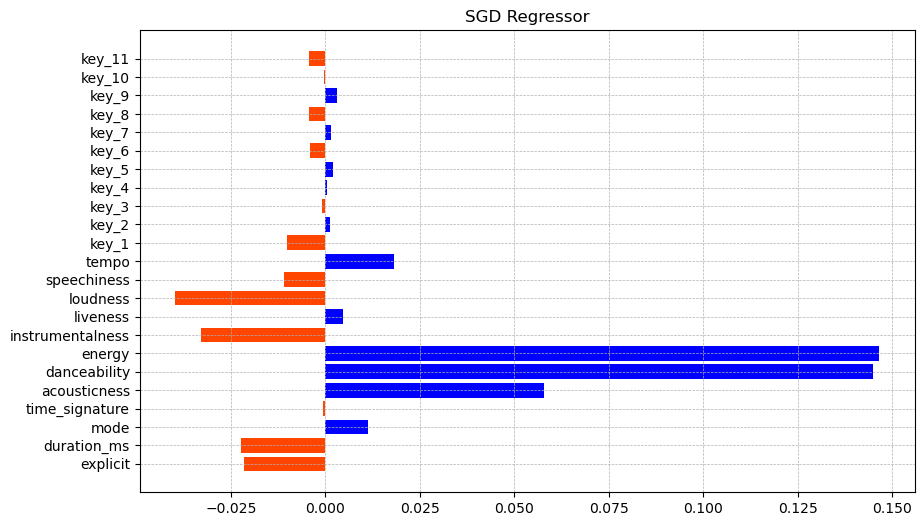

In [27]:
plot_coeficients(sgd_regr.best_estimator_, dev_X_sgd_train_std.columns.to_list())

**Observations**

- The best model for SGDRegressor reports via cross-validation an MAE of around 0.16224
- On the test set this model reports an MAE of around 0.16212
- Regarding the coefficients we notice that:
  - energy and danceability dominate (in that order)
  - acousticness, loudness and instrumentalness play an important role (in that order)

#### Random Forest Regressor

Performs regression. It is a bagging (bootstrap-aggregating) algorithm and actually a major-voting one.
Given a dataset it creates a set of N estimators where each estimator is a Decision tree.
For each tree a dataset is bootstrapped from the original dataset (sample selection with replacement) and given to the tree. It is called Random, due to the bootstrapping occured for the N estimators who now have a different set of data points. Hence the root of each tree can be different than other trees in the forest leading to diverse trees being built/expanded.
Another property is that not all features or their values are being examined as candidates to participate in the next round of tree growth.
Finally, the forest collects the votes of all trees and elects as a response the one with the most votes for classification, or takes a mean for regression.

In [28]:
# Data for random forest regression (using subsampling due to time constraints)
rf_size = 50_000
dev_rf = dev_b.sample(n=rf_size, replace=False, random_state=global_random_seed)

dev_X_rf = dev_rf.drop(columns=['valence'])
dev_y_rf = dev_rf['valence']
dev_X_rf_train, dev_X_rf_test, dev_y_rf_train, dev_y_rf_test = train_test_split(dev_X_rf, dev_y_rf, test_size=0.1, random_state=global_random_seed)

print("Dev Train dataset shape: {}".format(dev_X_rf_train.shape))
print("Dev Test dataset shape: {}".format(dev_X_rf_test.shape))

Dev Train dataset shape: (45000, 13)
Dev Test dataset shape: (5000, 13)


In [29]:
# Random forest regression

n_estimators = [100, 200, 300, 500, 700]
max_depth = [5, 8, 12, 16, 24, 28]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth + [None],
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

rf = RandomForestRegressor(random_state=global_random_seed)
rf_regr = RandomizedSearchCV(rf, params_grid, n_iter = 10, cv = 3, scoring='neg_mean_absolute_error',
                             verbose=1, random_state=global_random_seed, n_jobs = -1)
rf_regr.fit(dev_X_rf_train, dev_y_rf_train)

print("Best Params: " + str(rf_regr.best_params_))
print("Best score: " + str(-rf_regr.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 24}
Best score: 0.14667120525665364


In [30]:
predictions = rf_regr.predict(dev_X_rf_test)
mean_absolute_error(dev_y_rf_test, predictions)

0.14139756639430814

In [31]:
def plot_feature_importances(model, columns):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature importance of RandomForest Regressor')

    plt.barh(list(columns[indices][::-1]), list(importances[indices][::-1]),
            color='blue', height=0.2)
            
    plt.grid()
            
    for i, v in enumerate(list(importances[indices][::-1])):
        plt.text(v+ 0.001, i , str(round(v,2)), color='black')

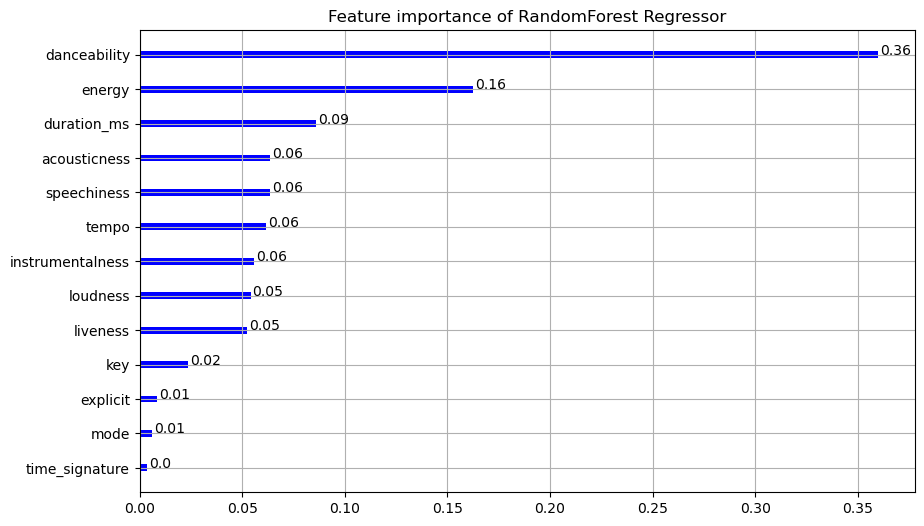

In [32]:
plot_feature_importances(rf_regr.best_estimator_, dev_X_rf_train.columns)

**Observations**

- The best model for RandomForestRegressor reports via cross-validation an MAE of around 0.14667
- On the test set this model reports an MAE of around 0.14139
- Regarding the feature importances we notice that:
  - danceability dominates
  - energy plays an important role
  - duration seems to help in some extent (but only by a small margin to the other variables)

#### Histogram-based Gradient Boosting Regression Tree

Performs regression. It is inspired by LightGBM, it is orders of magnitude faster than random-forest and provides better data modeling and better predictions
making it a great choice for our problem.
Feel free to check this excelent [comparison](HistGradientBoostingRegressor) of Random-Forest vs HistGradientBoostingRegressor.
Unfortunately this algorithm does not yet support/expose importances in order to plot them!

In [33]:
# Data for HistGradientBoosting regression

dev_X_hgb = dev_b.drop(columns=['valence'])
dev_y_hgb = dev_b['valence']
dev_X_hgb_train, dev_X_hgb_test, dev_y_hgb_train, dev_y_hgb_test = train_test_split(dev_X_hgb, dev_y_hgb, test_size=0.1, random_state=global_random_seed)

print("Dev Train dataset shape: {}".format(dev_X_hgb_train.shape))
print("Dev Test dataset shape: {}".format(dev_X_hgb_test.shape))

Dev Train dataset shape: (180000, 13)
Dev Test dataset shape: (20000, 13)


In [34]:
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

max_iter = [50, 90, 150, 200, 250, 300, 350]
max_depth = [5, 8, 12, 20, 24]
min_samples_leaf = [1, 2, 4, 8, 12, 24, 30]
max_leaf_nodes = [8, 11, 17, 21, 25, 31, 35, 41]
l2_regularization = 10.0 ** -np.arange(0,4)

categorical_features = ['key', 'mode', 'explicit']

params_grid = {
    'max_iter': max_iter,
    'max_depth': max_depth + [None],
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'l2_regularization': list(l2_regularization) + [0],
    'loss': ['absolute_error']
}

hg = HistGradientBoostingRegressor(random_state=global_random_seed, categorical_features=categorical_features)
hg_regr = RandomizedSearchCV(hg, params_grid, n_iter = 30, cv = 5, scoring='neg_mean_absolute_error',
                             verbose=1, random_state=global_random_seed, n_jobs = -1)
hg_regr.fit(dev_X_hgb_train, dev_y_hgb_train)

print("Best Params: " + str(hg_regr.best_params_))
print("Best score: " + str(-hg_regr.best_score_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'min_samples_leaf': 24, 'max_leaf_nodes': 31, 'max_iter': 350, 'max_depth': 24, 'loss': 'absolute_error', 'l2_regularization': 0.1}
Best score: 0.13956322066339574


In [35]:
predictions = hg_regr.predict(dev_X_hgb_test)
mean_absolute_error(dev_y_hgb_test, predictions)

0.1400457617693936

#### K Neighbors Regression (Using Facebook FAISS)

Performs regression. Uses the k most closest neighbors in order to make a prediction for a new given data point.
Usually the new point is being compared to most (e.g KD-Tree, Radius Tree) or all (Brute Force) avaialble data points
via a distance or similarity function(euclidean , manhattan, cosine). FAISS does not consider all points. It provides a specialized
data structure for performing the Approximate-k-NN technique. 

In [36]:
# Data for kNN-Regression

# First apply train test split
dev_X_knn = dev_a.drop(columns=['valence'])
dev_y_knn = dev_a['valence']
dev_X_knn_train, dev_X_knn_test, dev_y_knn_train, dev_y_knn_test = train_test_split(dev_X_knn, dev_y_knn, test_size=0.1, random_state=global_random_seed)

# Standardize the features for usage in linear regression
features = dev_X_knn_train.columns.to_list()
scaler = StandardScaler()

dev_X_knn_train_std = pd.DataFrame(columns=features)
dev_X_knn_test_std = pd.DataFrame(columns=features)

dev_X_knn_train_std[features] = scaler.fit_transform(dev_X_knn_train)
dev_X_knn_test_std[features] = scaler.transform(dev_X_knn_test)

print("Dev Train dataset shape: {}".format(dev_X_knn_train_std.shape))
print("Dev Test dataset shape: {}".format(dev_X_knn_test_std.shape))

Dev Train dataset shape: (180000, 23)
Dev Test dataset shape: (20000, 23)


In [37]:
# Create a class for kNN Regression using FAISS, with a scikit-learn like interface
class FaissKNeighborsRegressor:
    def __init__(self, k=5, centrality='mean'):
        self.k = k
        self.centrality = centrality
        self.centrality_func = np.mean if centrality == 'mean' else np.median

    def get_params(self, deep=True):
        return { "k": self.k, "centrality": self.centrality }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self  

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)

        predictions = []
        for neighbor_ids in indices:
            prediction = self.centrality_func(self.y.iloc[neighbor_ids])
            predictions.append(prediction)

        return predictions

params_grid = {
    'k': [3, 5, 7, 10, 13, 17, 22, 25, 30],
    'centrality': ['mean', 'median']
}

knn_regressor = FaissKNeighborsRegressor()

knn_regr = GridSearchCV(knn_regressor, params_grid, cv=3, scoring='neg_mean_absolute_error',
                        n_jobs=-1, verbose=1)
knn_regr.fit(dev_X_knn_train_std, dev_y_knn_train)

print("Best Params: " + str(knn_regr.best_params_))
print("Best score: " + str(-knn_regr.best_score_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'centrality': 'mean', 'k': 17}
Best score: 0.1599010426862745


In [38]:
predictions = knn_regr.predict(dev_X_knn_test_std)
mean_absolute_error(dev_y_knn_test, predictions)

0.1578623046470588

**Observations & Notes**

- KNeighborsRegressor from Sckit-Learn is extremely extremely slow. (I experimented with different sizes. It only works for datasets having less than 10k samples)
- FAISS (developed by Facebook) is a super optimized library (backed by C++) that provides fully efficient approximate k-NN indexes data structures, for very large datasets.
- The best model for FaissKNeighborsRegressor reports via cross-validation an MAE around 0.15990
- On the test set this model reports an MAE of around 0.15786
- There are no feature importances here nor coefficients. All features are used while searching on the constructed faiss index,
  and via euclidean distance calculation and comparison the k approximate "best" neighbors are returned.

#### XGBoost Regressor

Performs regression. It belongs to the family of boosting algorithms. Specifically it is an extremely efficient implementation of extreme gradient boosting.
It starts with a tree as a base estimator and on every iteration it creates a new tree estimator which focusses on the wrong predictions of the previous estimators. Each timestep works as a function with respect to the errors of previous estimators. This way derivative calculations (gradients) occur which can
update weights/importance of the involved estimators.
This technique is one of the most widely used and is sometimes comparable or may beat neural networks :-)

In [39]:
# Data for XGBoost regression

dev_X_xgb = dev_b.drop(columns=['valence'])
dev_y_xgb = dev_b['valence']
dev_X_xgb_train, dev_X_xgb_test, dev_y_xgb_train, dev_y_xgb_test = train_test_split(dev_X_xgb, dev_y_xgb, test_size=0.1, random_state=global_random_seed)

print("Dev Train dataset shape: {}".format(dev_X_xgb_train.shape))
print("Dev Test dataset shape: {}".format(dev_X_xgb_test.shape))

Dev Train dataset shape: (180000, 13)
Dev Test dataset shape: (20000, 13)


In [40]:
params_grid = {
    'max_depth':[8, 10, 12, 16, 20, 24],
    'min_child_weight':[1, 3, 5, 7],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(4,10)],
    'colsample_bytree':[i/10.0 for i in range(4,10)],
    'reg_alpha':[1e-4, 1e-3, 1e-2, 0, 0.1, 1]
}

xgb_regr = RandomizedSearchCV(XGBRegressor(random_state=global_random_seed), params_grid, cv=3, n_iter=150,
                              scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=global_random_seed)
xgb_regr.fit(dev_X_xgb_train, dev_y_xgb_train)

print("Best Params: " + str(xgb_regr.best_params_))
print("Best score: " + str(-xgb_regr.best_score_))

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best score: 0.14220871485116213


In [41]:
predictions = xgb_regr.predict(dev_X_xgb_test)
mean_absolute_error(dev_y_xgb_test, predictions)

0.14178149716101662

In [42]:
def plot_xgb_feature_importances(model, columns):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature importance of XGBoost')

    plt.barh(list(columns[indices][::-1]), list(importances[indices][::-1]),
            color='blue', height=0.2)
            
    plt.grid()
            
    for i, v in enumerate(list(importances[indices][::-1])):
        plt.text(v+ 0.001, i , str(round(v,2)), color='black')

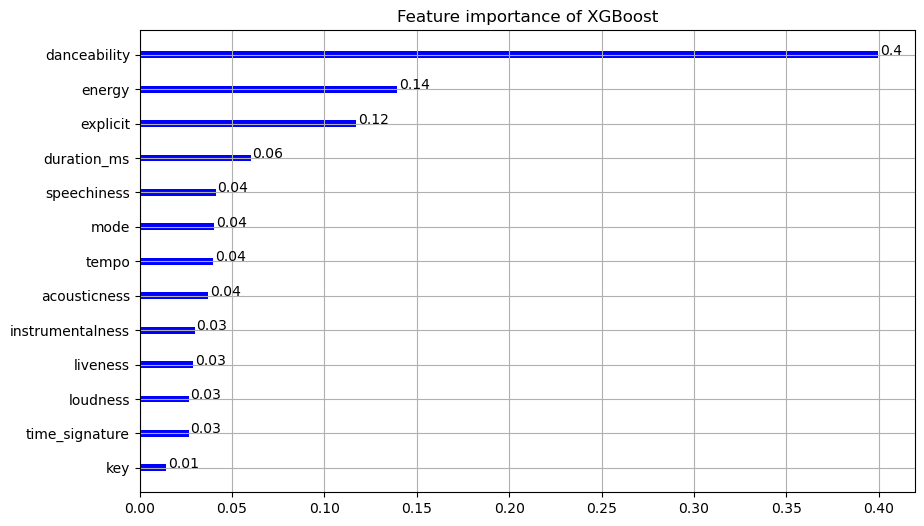

In [43]:
plot_xgb_feature_importances(xgb_regr.best_estimator_, dev_X_xgb_train.columns)

**Observations**

- The best model for XGBRegressor reports via cross-validation an MAE of around 0.14148
- On the test set this model reports an MAE of around 0.14096
- Regarding the feature importances we notice that:
  - danceability dominates
  - energy and explicit play an important role (in that order)
  - duration seems to help in some extent (but only by a small margin to the other variables)

#### LightGBM Regressor

Performs regression. The idea is the same as XGBoost, but LightGBM is an open-source implementation of gradient boosted trees by Microsoft

In [44]:
# Data for LightGBM regression

dev_X_lgb = dev_b.drop(columns=['valence'])
dev_y_lgb = dev_b['valence']
dev_X_lgb_train, dev_X_lgb_test, dev_y_lgb_train, dev_y_lgb_test = train_test_split(dev_X_lgb, dev_y_lgb, test_size=0.1, random_state=global_random_seed)

print("Dev Train dataset shape: {}".format(dev_X_lgb_train.shape))
print("Dev Test dataset shape: {}".format(dev_X_lgb_test.shape))

Dev Train dataset shape: (180000, 13)
Dev Test dataset shape: (20000, 13)


In [45]:
params_grid = {
    'num_leaves': [3, 5, 8, 10, 15, 25], 
    'max_depth': [-1, 3, 5, 7, 10, 13],
    'learning_rate': [0.05, 0.08, 0.15, 0.2, 0.25, 0.33],
    'reg_alpha':[0, 0.01, 0.033, 0.05, 1],
    'min_child_samples': [10, 30, 50, 70, 100],
    'min_child_weight': [1e-4, 1e-3, 1e-1, 1, 1e1]
}

lgbm_regr = RandomizedSearchCV(LGBMRegressor(random_state=global_random_seed, verbose=-1), params_grid, cv=3, n_iter=150,
                               scoring="neg_mean_absolute_error",n_jobs=-1, verbose=1, random_state=global_random_seed)
lgbm_regr.fit(dev_X_lgb_train, dev_y_lgb_train)

print("Best Params: " + str(lgbm_regr.best_params_))
print("Best score: " + str(-lgbm_regr.best_score_))

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'reg_alpha': 0.05, 'num_leaves': 25, 'min_child_weight': 10.0, 'min_child_samples': 100, 'max_depth': 7, 'learning_rate': 0.25}
Best score: 0.14147250027636096


In [46]:
predictions = lgbm_regr.predict(dev_X_lgb_test)
mean_absolute_error(dev_y_lgb_test, predictions)

0.141437078591123

<Axes: title={'center': 'Feature importance'}>

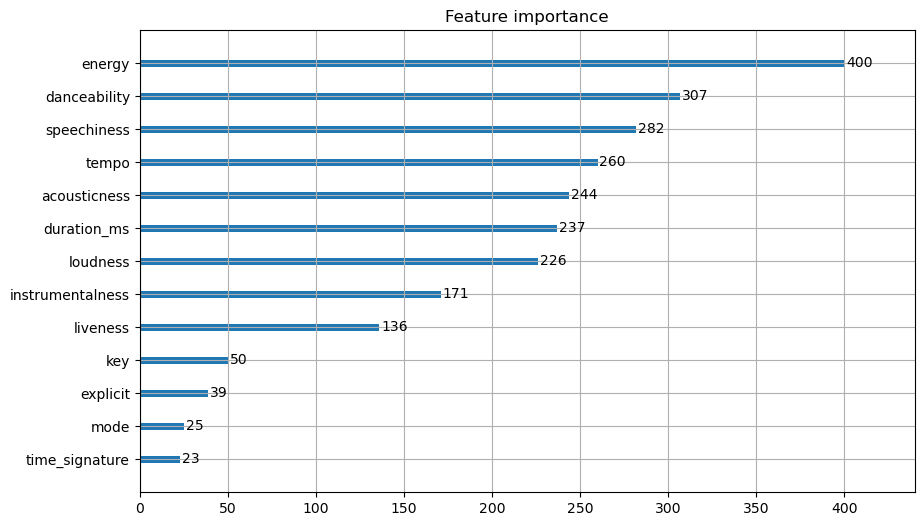

In [47]:
lgb.plot_importance(lgbm_regr.best_estimator_, figsize=(10, 6), xlabel=None, ylabel=None)

**Observations**

- The best model for LGBMRegressor reports via cross-validation an MAE of around 0.14147
- On the test set this model reports an MAE of around 0.14143
- Regarding the feature importances we notice that:
  - energy dominates
  - danceability and speechiness play an important role
  - tempo seems to help in some extent (but by a small margin to other variables)

#### Ensemble nodels via Stacking

Combine the best predictors (XGBoost and LightGBM) via stacking. Their predictions are passed to a final SGDRegressor estimator.
Here we do not perform cross-validation.

In [48]:
# Data for Stacked regression

dev_X_stack = dev_b.drop(columns=['valence'])
dev_y_stack = dev_b['valence']
dev_X_stack_train, dev_X_stack_test, dev_y_stack_train, dev_y_stack_test = train_test_split(dev_X_stack, dev_y_stack, test_size=0.1, random_state=global_random_seed)

print("Dev Train dataset shape: {}".format(dev_X_stack_train.shape))
print("Dev Test dataset shape: {}".format(dev_X_stack_test.shape))

Dev Train dataset shape: (180000, 13)
Dev Test dataset shape: (20000, 13)


In [49]:
estimators = [
    ('xgb', xgb_regr.best_estimator_),
    ('lgb', lgbm_regr.best_estimator_),
    ('hgb', hg_regr.best_estimator_)
]

sgdr_final = SGDRegressor(random_state=global_random_seed, early_stopping=True, max_iter=5000)

stacking_regr = StackingRegressor(estimators=estimators, cv='prefit', final_estimator=sgdr_final)
stacking_regr.fit(dev_X_stack_train, dev_y_stack_train)

StackingRegressor(cv='prefit',
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            l...
                                             min_child_weight=10.0,
                                             num_leaves=25,
                                             random_state=23122023,
                                             reg_alpha=0.05, verbose=-1)),
                              ('hgb',
                               HistGradientBoostingRegressor(categorical_features=['key',
                                                                                   'mode',
                                                                                   'explicit'],
                                                             l2_regularization=0.1,
                                                             loss='absolute_error',
                                                             max_depth=24,
                                                             max_iter=350,
                                                             min_samples_leaf=24,
                                                             random_state=23122023))],
                  final_estimator=SGDRegressor(early_stopping=True,
                                               max_iter=5000,
                                               random_state=23122023))

In [50]:
predictions = stacking_regr.predict(dev_X_stack_test)
mean_absolute_error(dev_y_stack_test, predictions)

0.14099735907343297

**Observations**

The stacked regression technique reports an MAE of around 0.13966 (which is better than all estimators)

### Preparing the final training dataset and the final holdout set

The following cells perform the following steps:

- Create a class for Spotify Web API (via spotipy library) and use it to download data for the holdout ids
- Persist the downloaded data to disk
- Read the holdout data into a dataframe and:
  - Drop un-needed columns ('uri', 'track_href', 'analysis_url', 'type')
  - Reorder the columns to match the the training data column ordering
- Exclude the holdout set from the 1.2m+ constructed dataset

In [51]:
# Set up a class as an API for Spotify using spotipy
from spotify_config import config

class SpotifyAPI:
    def __init__(self):
        credentials_manager = SpotifyClientCredentials(config['client_id'], config['client_secret'])
        self.client = spotipy.Spotify(client_credentials_manager=credentials_manager)

    # Get the explicit feature (bad words)
    def get_explicit(self, track_id):
        return int(self.client.track(track_id)['explicit'])
    
    # Get (audio and track) features in batches of 100 (as per spotify Web API requires)
    def get_features(self, track_ids, logging=True):
        features = {}
        start = 0
        batch_size = 100
        counter = 0

        while start < len(track_ids):
            tracks_batch = track_ids[start:start+batch_size]
            features_batch = self.client.audio_features(tracks_batch)

            for track_id, track_features in zip(tracks_batch, features_batch):
                counter +=1

                track_features.update({'explicit': self.get_explicit(track_id)})
                features.update({ track_id: track_features })

            if logging is True:
                print("Counter is {}".format(counter))

            # sleep for a sec
            time.sleep(1)

            # go to the next batch
            start += batch_size

        return features

# Initialize the API
api = SpotifyAPI()

In [52]:
# # Read the holdout set ids
# holdout_ids_df = pd.read_csv('data/spotify_ids_holdout.txt', header=None)
# holdout_ids_df.columns = ['song_id']

# # Download the data for the holdout set
# holdout_dict = api.get_features(holdout_ids_df['song_id'].to_list(), logging=False)

# # Put the downloaded data into a data frame and persist to disk
# df = pd.DataFrame.from_dict(holdout_dict).T
# df.head()

# df.to_csv('data/holdout_set.csv', index=False)

In [53]:
# Read the holdout set
holdout_df = pd.read_csv('data/holdout_set.csv').rename(columns={'id': 'song_id'})

# Drop columns
columns_to_drop = ['uri', 'track_href', 'analysis_url', 'type']
holdout_df = holdout_df.drop(columns=columns_to_drop)

# Reorder columns (to match the training data)
reordered = ['song_id', 'explicit', 'duration_ms', 'key',
             'mode', 'time_signature', 'acousticness', 'danceability',
             'energy', 'instrumentalness', 'liveness', 'loudness',
             'speechiness', 'valence', 'tempo']

holdout_df = holdout_df[reordered]

In [54]:
# Generic helper methods
class DataUtils:
    def __init__(self):
        pass

    @staticmethod
    def difference(df_a, df_b, column_name):
        b_list = df_b[column_name].to_list()
        diff = df_a[~df_a[column_name].isin(b_list)]

        return diff.copy()

    @staticmethod
    def transform(df, target_name, dummies = None, scaler = None, exclude = [], transform_only=False):
        transformed = df.copy()

        if dummies is not None:
            transformed = pd.get_dummies(df, columns=dummies, drop_first=True)

        if scaler is None:
            scaler = StandardScaler()

        excluded = [target_name]
        excluded.extend(exclude)

        columns = list(set(transformed.columns) - set(excluded))

        if transform_only is True:
            transformed[columns] = scaler.transform(transformed[columns])
        else:
            transformed[columns] = scaler.fit_transform(transformed[columns])

        return (scaler, transformed)

In [55]:
# Exclude the holdout set from spotify tracks
full_dataset = DataUtils.difference(spotify_tracks, holdout_df, 'song_id')

y_train = full_dataset['valence']
y_holdout = holdout_df['valence']

# Training and holdout dataset for SGDRegressor and Faiss-Knn
scaler, full_dataset_std = DataUtils.transform(full_dataset, 'valence', dummies=['key'], exclude=['song_id'])
_, holdout_dataset_std = DataUtils.transform(holdout_df, 'valence', dummies=['key'], scaler=scaler, exclude=['song_id'], transform_only=True)

X_train_std = full_dataset_std.drop(columns=['song_id', 'valence'])
X_holdout_std = holdout_dataset_std.drop(columns=['song_id', 'valence'])

# Training dataset for the Trees
X_train = full_dataset.drop(columns=['song_id', 'valence']).copy()
X_holdout = holdout_df.drop(columns=['song_id', 'valence']).copy()

### Training the final models with the full dataset

In [56]:
# SGDRegressor
sgd_reg_final = SGDRegressor(penalty='elasticnet', loss='huber', learning_rate='invscaling', alpha=1e-05,
                             max_iter=5000, random_state=global_random_seed)
sgd_reg_final.fit(X_train_std, y_train)

# FaissKNeighborsRegressor
knn_reg_final = FaissKNeighborsRegressor(k=17, centrality='mean')
knn_reg_final.fit(X_train_std, y_train)

# HistGradientBoostingRegressor
categorical_features = ['key', 'mode', 'explicit']
hgb_reg_final = HistGradientBoostingRegressor(random_state=global_random_seed, categorical_features=categorical_features,
                                              min_samples_leaf=24, max_leaf_nodes=31, max_iter=350, max_depth=24,
                                              loss='absolute_error', l2_regularization=0.1)
hgb_reg_final.fit(X_train, y_train)


# XGBRegressor
xgb_reg_final = XGBRegressor(subsample=0.9, reg_alpha=0.01, min_child_weight=1, max_depth=8, gamma=0.1,
                             colsample_bytree=0.7, random_state=global_random_seed)
xgb_reg_final.fit(X_train, y_train)

# LGBMRegressor
lgb_reg_final = LGBMRegressor(reg_alpha=0.05, num_leaves=25, min_child_weight=10.0, min_child_samples=100,
                              max_depth=7, learning_rate=0.25, random_state=global_random_seed)
lgb_reg_final.fit(X_train, y_train)

# Stacked Regressor
stack_estimators = [
    ('xgb', xgb_reg_final),
    ('lgb', lgb_reg_final),
    ('hgb', hgb_reg_final)
]

stacked_reg_final = StackingRegressor(estimators=stack_estimators, cv='prefit',
                                      final_estimator=SGDRegressor(random_state=global_random_seed, early_stopping=True, max_iter=5000))
stacked_reg_final.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 1216078, number of used features: 13
[LightGBM] [Info] Start training from score 0.428757


StackingRegressor(cv='prefit',
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            l...
                                             min_child_weight=10.0,
                                             num_leaves=25,
                                             random_state=23122023,
                                             reg_alpha=0.05)),
                              ('hgb',
                               HistGradientBoostingRegressor(categorical_features=['key',
                                                                                   'mode',
                                                                                   'explicit'],
                                                             l2_regularization=0.1,
                                                             loss='absolute_error',
                                                             max_depth=24,
                                                             max_iter=350,
                                                             min_samples_leaf=24,
                                                             random_state=23122023))],
                  final_estimator=SGDRegressor(early_stopping=True,
                                               max_iter=5000,
                                               random_state=23122023))

**Note**

RandomForestRegressor was excluded from the final training since it takes an extremely long time to train for a dataset of our size (aka 1.2 million samples)

### Predicting on the given holdout set

We create a dataframe which stores the held out (given) song ids, the actual valence and the predicted valence from every algorithm.
We persist the predictions dataframe to disk. Then we compute the MAE for every algorithm and put the result into a dataframe.
We will keep the ML model with the smallest MAE on the given held out set.

In [57]:
predictions_df = pd.DataFrame(columns=['song_id', 'actual', 'sgd', 'faiss_knn', 'hgb', 'xgb', 'lgbm', 'stacking'])

predictions_df['song_id'] = holdout_df['song_id']
predictions_df['actual'] = holdout_df['valence']
predictions_df['sgd'] = sgd_reg_final.predict(X_holdout_std)
predictions_df['faiss_knn'] = knn_reg_final.predict(X_holdout_std)
predictions_df['hgb'] = hgb_reg_final.predict(X_holdout)
predictions_df['xgb'] = xgb_reg_final.predict(X_holdout)
predictions_df['lgbm'] = lgb_reg_final.predict(X_holdout)
predictions_df['stacking'] = stacked_reg_final.predict(X_holdout)

predictions_df.to_csv('data/spotify_valence_predictions.csv', index=False)

In [58]:
# Read the predictions
valence_predictions = pd.read_csv('data/spotify_valence_predictions.csv')

mean_absolute_errors = [
    mean_absolute_error(valence_predictions['actual'], valence_predictions['sgd']),
    mean_absolute_error(valence_predictions['actual'], valence_predictions['faiss_knn']),
    mean_absolute_error(valence_predictions['actual'], valence_predictions['hgb']),
    mean_absolute_error(valence_predictions['actual'], valence_predictions['xgb']),
    mean_absolute_error(valence_predictions['actual'], valence_predictions['lgbm']),
    mean_absolute_error(valence_predictions['actual'], valence_predictions['stacking'])
]

# Compute the MAE for every algorithm
mae_df = pd.DataFrame(columns=['model', 'mae'])
mae_df['model'] = ['sgd', 'faiss_knn', 'hgb', 'xgb', 'lgbm', 'stacking']
mae_df['mae'] = mean_absolute_errors

# Sort the dataframe to elect the best model
mae_df.sort_values(by=['mae'])

,model,mae
3,xgb,0.156590
5,stacking,0.157358
4,lgbm,0.161313
2,hgb,0.161376
0,sgd,0.166205
1,faiss_knn,0.169905


### The Verdict :-)

So from the above table, reporting the MAE on the given holdout set for every algorithm, we decide that the best model is the XGBoost Regressor
reporting an MAE of **0.156590**